In [14]:
import pandas as pd
import datetime

from lib.ts_backtester import Backtester
from strategies.rsi_2.S_rsi_plot import plot

import pandas_ta as ta
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId

# Make sure that backtester is defined or not
backtester = Backtester(
    candle_time_bucket=TimeBucket.h4,
    stop_loss_time_bucket=TimeBucket.m1,
    trading_pair=[(ChainId.ethereum, "uniswap-v3", "WETH", "USDC", 0.0005)],
    start_at=datetime.datetime(2021, 1, 1),
    end_at=datetime.datetime(2023, 6, 4),
    reserve_currency="USDC",
)

In [15]:
ma_long = 295
ma_short = 11
rsi_cutt = 9
atr_distance = 2.5
trailing_stop_loss_activation_level = 1.05
trailing_stop_loss_pct = 0.995

import numpy as np


def get_signals(candles):
    close = candles["close"].iloc[-1]
    low = candles["low"].iloc[-1]

    # Calculate indicators
    sma_short = ta.sma(candles["close"], length=ma_short)
    sma_short = ta.sma(candles["close"], length=ma_short).iloc[-1]
    sma_long = ta.sma(candles["close"], length=ma_long).iloc[-1]
    rsi = ta.rsi(candles["close"], length=2).iloc[-1]
    atr = ta.atr(candles["high"], candles["low"], candles["close"], length=14).iloc[-1]

    # Calculate signals

    entry = close <= sma_short and close >= sma_long and rsi <= rsi_cutt
    exit = close > sma_short
    sl = low - atr * atr_distance
    sl_pct = float(round(sl / candles["open"].iloc[-1], 6))

    indicators = {
        "sma_short": sma_short,
        "sma_long": sma_long,
        "rsi": rsi,
        "atr": atr,
    }
    return entry, exit, sl, sl_pct, indicators


def calculate_size(state, close):
    cash = state.portfolio.get_current_cash()
    return cash * 0.99


current_sl = np.inf


def loop(timestamp, universe, state, pricing_model, cycle_debug_data):
    # The pair we are trading
    trades = []
    pair = universe.pairs.get_single()

    candles: pd.DataFrame = universe.candles.get_single_pair_data(
        timestamp, sample_count=ma_long
    )

    if len(candles) < ma_long:
        # Backtest starting.
        # By default get_single_pair_data() returns the candles prior to the `timestamp`,
        # the behavior can be changed with get_single_pair_data(allow_current=True).
        # At the start of the backtest, we do not have any previous candle available yet,
        # so we cannot ask the the close price.
        return trades

    current_price = candles["close"].iloc[-1]

    entry, exit, sl, sl_pct, indicators = get_signals(candles)
    # global current_sl

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)
    buy_amount = calculate_size(state, current_price)

    if not position_manager.is_any_open():
        if entry:
            # print(sl)
            # sl = 0.98
            # current_sl = sl
            trades += position_manager.open_1x_long(pair, buy_amount)
            pos = position_manager.get_current_position()
            pos.stop_loss = float(sl)
            # trades += position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=sl_pct)
    else:
        if exit:
            # current_sl = np.inf
            trades += position_manager.close_all()

        # Update the trailing stop loss

        # Switch to trailing stop loss after take profit level reached
        #position = position_manager.get_current_position()
        #if current_price >= position.get_opening_price() * trailing_stop_loss_activation_level:
        #    position.trailing_stop_loss_pct = trailing_stop_loss_pct
        #    position.stop_loss = None

    plot(state, timestamp, indicators)

    return trades


start_at = datetime.datetime(2021, 7, 1)
end_at = datetime.datetime(2023, 6, 4)

In [16]:
backtester.backtest(start_at, end_at, loop)
backtester.stats()
# backtester.general_stats()


  0%|          | 0/60739200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 171 trades
Total return: 106.72%
Max Drawdown: -18.72%


In [17]:
# backtester.plot()

### Price action and technical indicators

- Plot the prica action for the trading pair we backtested.
- Overlay trades on the top of technical indicators

In [18]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

state = backtester.state
universe = backtester.universe

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=start_at,
    end_at=end_at,
    volume_bar_mode=VolumeBarMode.separate,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

# figure.show()


### Equity curve and drawdown

Visualise equity curve and related performnace over time.

- Returns

- Drawdown

- Daily returns



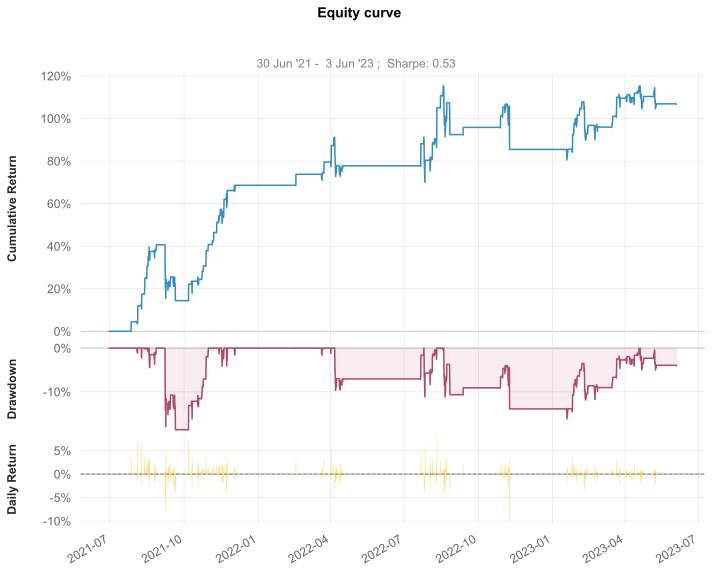

In [19]:
from tradeexecutor.backtest.notebook import setup_charting_and_output
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

setup_charting_and_output()

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

### Returns monthly breakdown

- Monthly returns
- Best day/week/month/year


/Users/moo/Library/Caches/pypoetry/virtualenvs/ts-strategy-NgEO31rc-py3.10/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



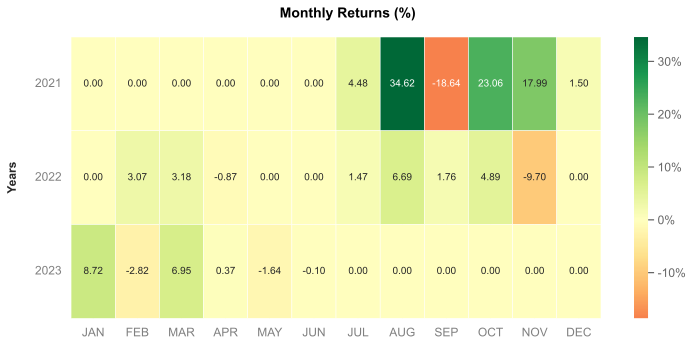

In [20]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

### Returns distribution

Show the difference between good and bad trading periods.

- Daily/montly/yearly

- Best/worst/avg.

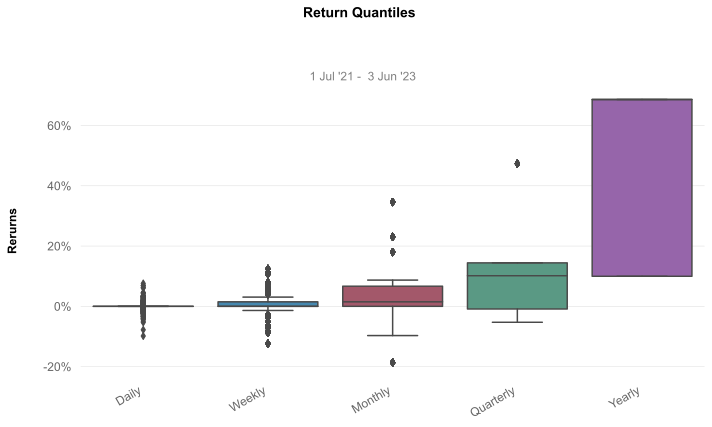

In [21]:
from tradeexecutor.visual.equity_curve import visualise_returns_distribution

visualise_returns_distribution(returns)

### Position chart

- Visualise individual positions over the price timeline

- Hover your mouse on the position marker circle to get its underlying details

- Positions closed for profit are marked green while losing ones are red

In [ ]:
candles = universe.universe.candles.get_candles_by_pair(universe.get_single_pair().internal_id)

figure2 = visualise_single_pair_positions_with_duration_and_slippage(
    state,
    candles,
    start_at=start_at,
    end_at=end_at,
)

figure2.show()

### Benchmarks

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold ETH


In [ ]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "Our strategy",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=start_at,
    end_at=end_at,
    height=800
)

fig.show()

### Analyse trade statistics

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [ ]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Trading metrics

Overview of trading metrics.

- Returns
- Cash balance change
- Won/lost trades
- Fees paid


In [ ]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

### Performance metrics

Here is an example how to use Quantstats library to calculate the tearsheet metrics for the strategy with advanced metrics.
The metrics include popular [risk-adjusted return comparison metrics](https://tradingstrategy.ai/glossary/risk-adjusted-return).

This includes metrics like:

- Sharpe
- Sortino
- Max drawdown

**Note**: These metrics are based on equity curve and returns. Analysis here does not go down to the level of an individual trade or a position.
Any consecutive wins and losses are measured in days, not in trade or candle counts.

In [ ]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

### Position and trade timeline

Display all positions and how much profit they made.

In [ ]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [ ]:
print("All ok")